In [464]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyproj import CRS, Proj, transform

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

import pystan

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error, recall_score, precision_score, roc_auc_score

In [2]:
sns.set()

plt.rcParams['figure.figsize'] = (12, 8)


In [103]:
%load_ext jupyterstan

In [3]:
df = pd.read_excel("counter_data.xlsx")

In [4]:
df = df[['CounterReadingID', 'StartTime', 'EndTime', 'Visits', 'CounterID_ASTA', 'ASTA_Counters.RegionalUnit', 'PAVE_Counters.CoordinateNorth', 'PAVE_Counters.CoordinateEast']]
df.columns = ['id', 'start', 'end', 'visits', 'counter', 'park', 'north', 'east']

df = df.dropna()
df['duration'] = df.end - df.start

df = df.astype({"visits": int, "counter": int, "park": int, 'north': int, 'east': int})

In [5]:
df_hourly = df[(df.duration == np.timedelta64(1, 'h')) & (df.park == 625)].sort_values('start')

In [16]:
df_counters = df_hourly.groupby('counter').resample('1d', on='start').sum()[['visits']]  # only daily data in Nuuksio

In [368]:
df_flat = pd.DataFrame(df_counters.to_records())

In [369]:
medians = df_flat.groupby('counter').median()['visits']

In [371]:
df_flat['week_day'] = df_flat.start.dt.dayofweek
df_flat['weekend'] = df_flat.week_day.isin([5, 6]).astype(int)
df_flat['month'] = df_flat.start.dt.month
df_flat['day'] = df_flat.start.dt.day

df_flat = df_flat.sort_values(by=['counter', 'start'])

df_flat['busy'] = (df_flat['visits'] > df_flat['visits'].median()).astype(int)
df_flat['counter_busy'] = df_flat.apply(lambda x: x[2] >= medians[x[0]], 1).astype(int)

In [372]:
df_flat = df_flat[df_flat.visits > 0]

In [473]:
x_data = df_flat[['month', 'weekend', 'week_day', 'day', 'counter']].values
y_data = df_flat[['counter_busy']].values.ravel()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

In [474]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10)
# clf = SVC()

clf.fit(x_train, y_train)

clf.score(x_test, y_test)

0.7569118414188837

In [462]:
y_data = df_flat[['visits']].values.ravel()

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

In [463]:
clf = RandomForestRegressor(n_estimators=100, max_depth=10)
# clf = SVC()

clf.fit(x_train, y_train)

clf.score(x_test, y_test)

0.6019333745022577

In [469]:
np.sqrt(mean_squared_error(y_test, clf.predict(x_test)))

33.21005728362416

In [489]:
weather = pd.read_csv('weather.csv')

weather.columns = ['date', 'T', 'P0', 'P', 'U', 'DD', 'Ff', 'ff10', 'WW', 'W\'W', 'c', 'VV', 'Td']

weather.date = pd.DatetimeIndex(weather.date)

In [506]:
weather

,date,T,P0,P,U,DD,Ff,ff10,WW,W'W,c,VV,Td
0,2019-10-31 23:50:00,1.0,754.2,759.0,93.0,Wind blowing from the west,4,NaN,NaN,NaN,No Significant Clouds,10.0 and more,0.0
1,2019-10-31 23:20:00,1.0,754.2,759.0,93.0,Wind blowing from the west,5,NaN,NaN,NaN,No Significant Clouds,10.0 and more,0.0
2,2019-10-31 22:50:00,1.0,754.2,759.0,93.0,Wind blowing from the west,4,NaN,NaN,NaN,No Significant Clouds,10.0 and more,0.0
3,2019-10-31 22:20:00,2.0,754.2,759.0,87.0,Wind blowing from the west,4,NaN,NaN,NaN,No Significant Clouds,10.0 and more,0.0
4,2019-10-31 21:50:00,2.0,754.2,759.0,87.0,Wind blowing from the west,4,NaN,NaN,NaN,Few clouds (10-30%) 450 m,10.0 and more,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83276,2015-01-01 02:20:00,4.0,753.0,757.7,87.0,Wind blowing from the west,4,NaN,NaN,NaN,"Few clouds (10-30%) 1290 m, broken clouds (60-...",10.0 and more,2.0
83277,2015-01-01 01:50:00,4.0,753.0,757.7,87.0,Wind blowing from the west,5,NaN,NaN,NaN,"Few clouds (10-30%) 1200 m, broken clouds (60-...",10.0 and more,2.0
83278,2015-01-01 01:20:00,4.0,753.0,757.7,87.0,Wind blowing from the west,4,NaN,NaN,NaN,No Significant Clouds,10.0 and more,2.0
83279,2015-01-01 00:50:00,4.0,753.0,757.7,87.0,Wind blowing from the west,4,NaN,NaN,NaN,No Significant Clouds,10.0 and more,2.0


In [509]:
weather.resample('1d', on='date')['T'].mean()

date
2015-01-01     2.851064
2015-01-02     0.177778
2015-01-03     1.486486
2015-01-04     1.372093
2015-01-05     9.045455
                ...    
2019-12-06    15.125000
2019-12-07    13.458333
2019-12-08    18.166667
2019-12-09    14.833333
2019-12-10     9.104167
Freq: D, Name: T, Length: 1805, dtype: float64

# FEATURES:

1. Day of the week
2. Month
3. Day number

In [44]:
counter_ids = np.unique(df_counters.index.get_level_values('counter'))

In [276]:
counter_ids

array([ 912,  922, 1043, 1050, 1225, 1246])

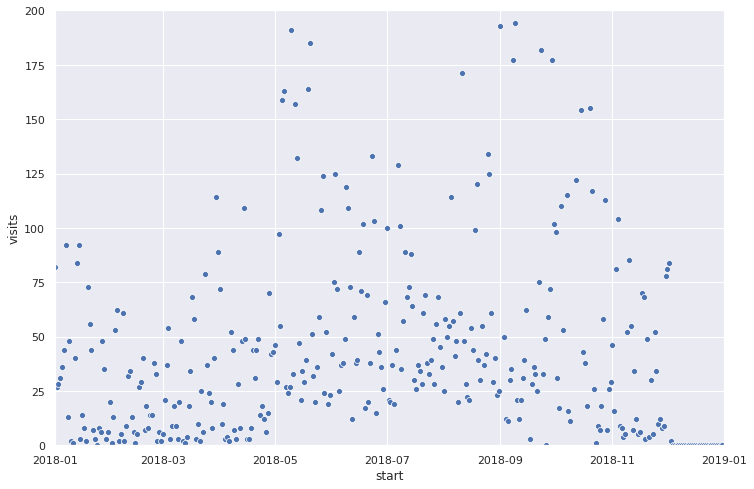

(365, 1)

In [275]:
idx = 0  # 0..5
year_start = 2018
year_end = year_start + 1

counter_id = counter_ids[idx]

df_plot = df_counters[df_counters.index.get_level_values('start') < pd.datetime(year_end, 1, 1)]
df_plot = df_plot[pd.datetime(year_start, 1, 1) <= df_plot.index.get_level_values('start')]

sns.scatterplot(x=df_plot.loc[counter_id].index, y='visits', data=df_plot.loc[counter_id])
plt.xlim(pd.datetime(year_start, 1, 1), pd.datetime(year_end, 1, 1))
plt.ylim(0, 200)
plt.show()
df_plot.loc[counter_id].shape

In [165]:
coords = df_hourly.apply(lambda x: (x[7], x[6]), axis=1).unique()

In [166]:
# Coordinate conversion template
crs = CRS.from_epsg(3067)

in_proj = Proj('epsg:3067')
out_proj = Proj('merc')

# x, y = transform(in_proj, out_proj, df_hourly.east.values[1000], df_hourly.north.values[1000])

# x, y

In [167]:
merc_coords = []
for east, north in coords:
    merc_coords.append(transform(in_proj, out_proj, east, north))

In [168]:
merc_coords

[(60.303525451006834, 24.550391008969527),
 (60.33073081360451, 24.492838046488888),
 (60.27581963490531, 24.46368928427852),
 (60.326924542956334, 24.495358359272675),
 (60.29819039594651, 24.45628974906327),
 (60.28242199633351, 24.505873789599413)]